# Know your business through exploratory analysis and cohort analysis
<img src="https://images.unsplash.com/photo-1553484771-371a605b060b?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=1350&q=80" width=1200 height=800 />

# Dataset

In this project, I use a dataset concerning online retail from UCI ML repository. It includes 8 variables and records 4372 customers as well as their orders, which are around 25,900 unique orders of 4223 products. Each row represents an item within a purchase. InvoiceNo is used for recognizing different transactions, and CustomerIDtells us who made this purchase.

# Part 1. Preprocessing

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import calendar
%matplotlib inline
import seaborn as sns
import warnings
from datetime import datetime
warnings.filterwarnings("ignore")

In [11]:
#retail = pd.read_excel('Online Retail.xlsx')
retail = pd.read_csv('Online Retail.csv')
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'])
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### 1-1. Examining datatypes of each feature

In [12]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


* `CustomerID` is a float variable here, wheras it should be a string variable. Consequently, we sholud correct it later.

### 1-2. Examining missing values

In [13]:
retail.isna().mean()

InvoiceNo      0.000000
StockCode      0.000000
Description    0.002683
Quantity       0.000000
InvoiceDate    0.000000
UnitPrice      0.000000
CustomerID     0.249267
Country        0.000000
dtype: float64

* 25% of `CutomerID` and 2% of `Description` are unknown. In particular, rows with missing `Descriptions` also entailed with unknown `CustomerIDs`.

* However, to trace the purchase history of each customer, the `CustomerID` variable is essential. Any missing value let us fail to identify each transaction belongs to which customer. Thus, it is necessary to drop rows with unidentified `CustomerID` later.

### 1-3. Examining duplicated rows

In [14]:
print(('{0:d} rows are duplicated and it accounts for {1:.2%} of the entire dataset'
       .format(retail.duplicated().sum(),                                                                               
              retail.duplicated().sum() / len(retail))))

5268 rows are duplicated and it accounts for 0.97% of the entire dataset


* If two rows have the same value in each column, we can consider them as duplicated rows.
* Through the `duplicated()` function, I find duplicated rows actually exist in this dataset. Although they are only a small proportion of data, they are able to influence the results. Thus, we should get rid of them.

### 1-4. Descriptive statistics for numerical features

In [15]:
retail[['Quantity','UnitPrice']].describe().round(2)

,Quantity,UnitPrice
count,541909.00,541909.00
mean,9.55,4.61
std,218.08,96.76
min,-80995.00,-11062.06
25%,1.00,1.25
50%,3.00,2.08
75%,10.00,4.13
max,80995.00,38970.00


* It is unreasonable that `Quantity` and `UnitPrice` have negative values and extreme values.

* Negative values are due to cancellations of transactions. Although it does not affect the aggregation of sales, it causes errors when computing the number of transactions because each canceled order have two invoice numbers, one of which starts from "C" and has negative values. Thus, we should filter out those repeated records. 

* Extreme values may lead to imbalanced clusters when implementing clustering, and thus I will deal with them in the next article.

### 1-5 Dealing with the above problems

Now, it's time to solve the issues mentioned earlier. To begin with, I dealt with missing values, repeated rows, and the incorrect data type. 

In [16]:
# Remove rows with unknown customer ID
retail = retail.loc[retail['CustomerID'].notna()]

# Remove duplicate rows
retail[~retail.duplicated()]

# Change the datatype of CustomerID
retail['CustomerID'] = retail['CustomerID'].astype('int').astype('str') 

As for the problem of negative values, it is no doubt that InvoiceNo starting with "C" should be discarded. Yet, what about their original transactions? If we remove canceled ones, their original orders are still there. Although customers made these purchases before, the corporate had never received money, and thus the value of revenue might be exaggerated. If we get rid of those original transactions simultaneously, some footprints of customers will be erased.

To address this complicated situation, I decided to preserve those original records but set their UnitPrice as 0, meaning that the firm did not gain profit from these orders.

In [17]:
# Find cancelled orders and thier original orders
cancelled = retail.loc[retail['InvoiceNo'].str.startswith('C', na=False), 'InvoiceNo'].unique()
original =  [i.replace('C', '') for i in cancelled]

# Filter out the cancelled orders
retail = retail[~retail['InvoiceNo'].isin(cancelled)]
                                         
# Reduce revenue in the original orders to 0
retail.loc[retail['InvoiceNo'].isin(original), 'UnitPrice'] = 0                                         

### 6. Creating a revenue variable
Finally, Quantity and UnitPrice are not helpful for our research. Nonetheless, if we twist them through multiplying them together, they will turn into a critical metric to quantify how much revenue the business can earn.

In [19]:
# Calculating the total amount of payment for each InvoiceNo
retail['revenue'] = retail['Quantity']*retail['UnitPrice']

In [20]:
retail.describe().round(2)

,Quantity,UnitPrice,revenue
count,397924.00,397924.00,397924.00
mean,13.02,3.12,22.39
std,180.42,22.10,309.06
min,1.00,0.00,0.00
25%,2.00,1.25,4.68
50%,6.00,1.95,11.80
75%,12.00,3.75,19.80
max,80995.00,8142.75,168469.60


In [21]:
retail[['InvoiceNo','CustomerID', 'Description', 'Country']].nunique()

InvoiceNo      18536
CustomerID      4339
Description     3877
Country           37
dtype: int64

# Part 2. Exploratory Analysis

In [22]:
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

In [23]:
color_dict = {'g':'#35b494', 'y': '#f7b025', 'r':'#ea5345', 'b':'#79b9ce', 'title':'#595959'}
params = {i:color_dict['title'] for i in ["ytick.color", "xtick.color","axes.labelcolor","text.color"]}

In [25]:
def plot_style():
    plt.style.use('ggplot')
    mpl.rcParams['axes.facecolor'] = 'white'
    plt.rc('font', **{'size'   : 14})
    plt.rcParams.update(params)

### 2-1. Monthly Sales
The goal of marketing is to increase revenue, so it is a good start to investigate the company's profitability. 

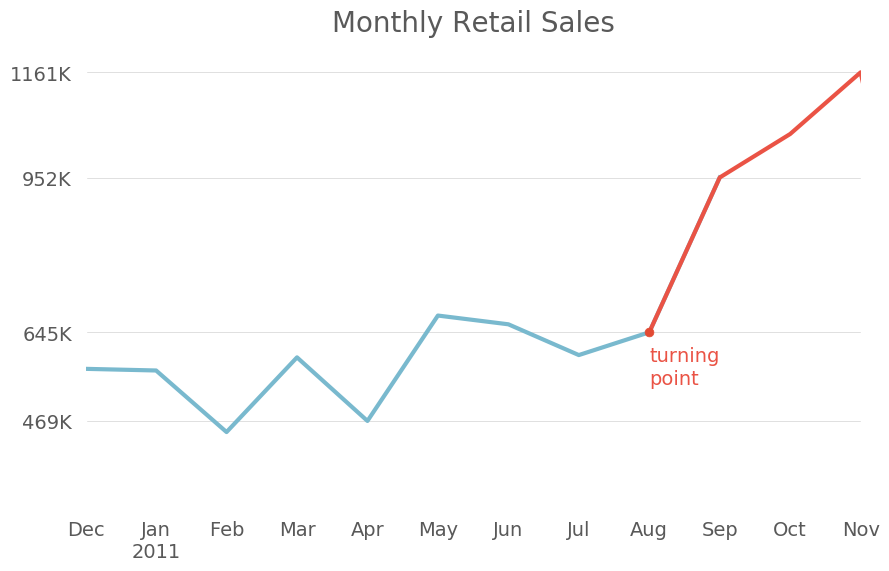

In [29]:
retail['yearmonth'] = retail['InvoiceDate'].dt.to_period('M')
monthly_sales = retail.groupby(['yearmonth']).agg({'revenue':'sum'})

plot_style()
fig, ax1 = plt.subplots(figsize=[10,6], facecolor='white', dpi=100)

monthly_sales.loc[:'2011-09','revenue'].plot(zorder=5, color=color_dict['b'], linewidth=3, ax=ax1)#35b494
monthly_sales.loc['2011-08':,'revenue'].plot(zorder=5, color=color_dict['r'], linewidth=3, ax=ax1)
plt.scatter('2011-08', monthly_sales.loc['2011-08','revenue'], zorder=10, s=40)

ax1.set_yticks(monthly_sales.iloc[[4,8,9,11], 0])
ax1.set_yticklabels(str(i) + 'K' for i in (monthly_sales.iloc[[4,8,9,11], 0]/1e03).astype('int'))#[str(i) + 'K' for i in np.arange(40,160+1,40)]

ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_ylim(30e04, 120e04)
ax1.set_xlim('2010-12-01', '2011-11-01')

ax1.tick_params(axis='both', which='both', length=0, pad=10)
ax1.grid(color='lightgrey', which='major', axis='y', linewidth=0.5)

ax1.text('2011-08',monthly_sales.iloc[8, 0]*0.91, 'turning', color='#ea5345')
ax1.text('2011-08',monthly_sales.iloc[8, 0]*0.84, 'point', color='#ea5345')

plt.title('Monthly Retail Sales', fontsize=20, color='#595959', y=1.03)
plt.savefig('Monthly Retail Sales', facecolor='white', bbox_inches="tight", dpi=85)
#plt.show()

Two observations from the monthly retail sales: 

* Overall, the sales went up across months. It is good news for a company.

* Revenue after August had a significant change. In the first half of the year are relatively low and remained between 469K to 645K, whereas the monthly revenue significantly rose from September. I suggest that some changes happened in marketing strategies during August and September. 

### 2-2. The Growth Rate of Sales

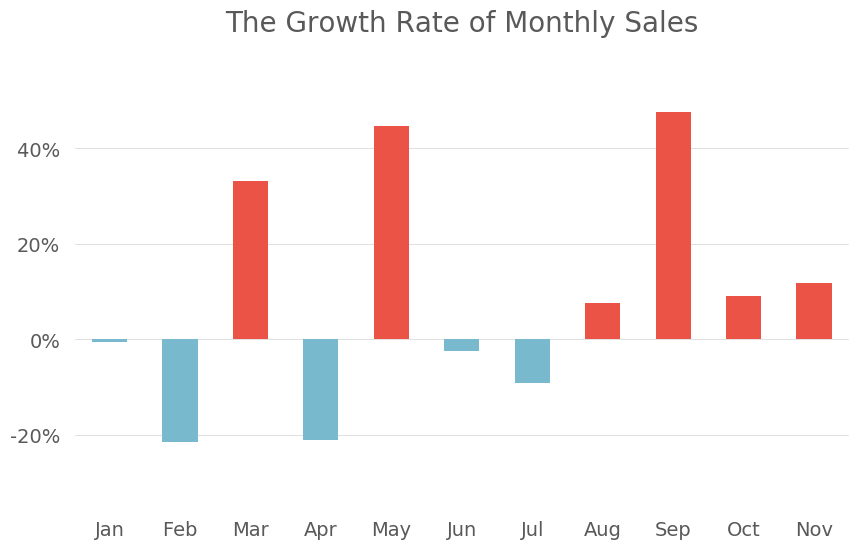

In [49]:
monthly_sales['growth_rate'] = monthly_sales.pct_change()

plot_style()

fig, ax = plt.subplots(figsize=[10,6], facecolor='white', dpi=100)
colors = monthly_sales.loc['2011-01':'2011-11', 'growth_rate'].apply(lambda x: color_dict['r'] if x > 0 else color_dict['b'])

ax = monthly_sales.loc['2011-01':'2011-11', 'growth_rate'].plot.bar(color=colors)

ax.set_ylim(-0.35,0.6)
ax.set_yticks(np.arange(-0.2,0.6,0.2))
ax.set_yticklabels(['{:,.0%}'.format(i) for i in np.arange(-0.2,0.6,0.2)])

ax.set_xlabel('')
ax.set_xticklabels([i for i in calendar.month_abbr][1:12], rotation=0)

ax.tick_params(axis='both', which='both', length=0,pad=10)
ax.grid(color='lightgrey', which='major', axis='y', linewidth=0.5)


plt.title('The Growth Rate of Monthly Sales', fontsize=20, y=1.03)

plt.savefig('The Growth Rate of Monthly Sales', facecolor='white', bbox_inches="tight", dpi=85)

* Before August, revenue had been boosted two times, which happened in March and May. However, the increasing trend did not go on to the next month.

* After August, the revenue continued to grow without going down. 

### 2-3. The Composition of Customer for Each Month

In [33]:
# Find the first date a customer made a purchase
retail['first_date'] = retail.groupby('CustomerID')['InvoiceDate'].transform('min')

# Identify how many months a customer stay from the invoice date
retail['first_ym'] = retail['first_date'].dt.to_period('M')
retail['retain_months'] = 12*(retail['yearmonth'].dt.year - retail['first_ym'].dt.year) + (retail['yearmonth'].dt.month - retail['first_ym'].dt.month)

# The composition of customers for each month
monthly_customers = pd.DataFrame(retail.groupby(['yearmonth'])['CustomerID'].nunique()).rename(columns={'CustomerID':'total'})
monthly_customers['new'] = retail.groupby('first_ym')['CustomerID'].nunique()
monthly_customers['existing'] = monthly_customers['total'] - monthly_customers['new']
monthly_customers['sales_new'] = retail.loc[retail['yearmonth'] == retail['first_ym']].groupby('yearmonth')['revenue'].sum()
monthly_customers['sales_existing'] = monthly_sales['revenue'] - monthly_customers['sales_new']
monthly_customers['sales_new_ratio'] = monthly_customers['sales_new'] / monthly_sales['revenue']
monthly_customers = monthly_customers.iloc[1:12]

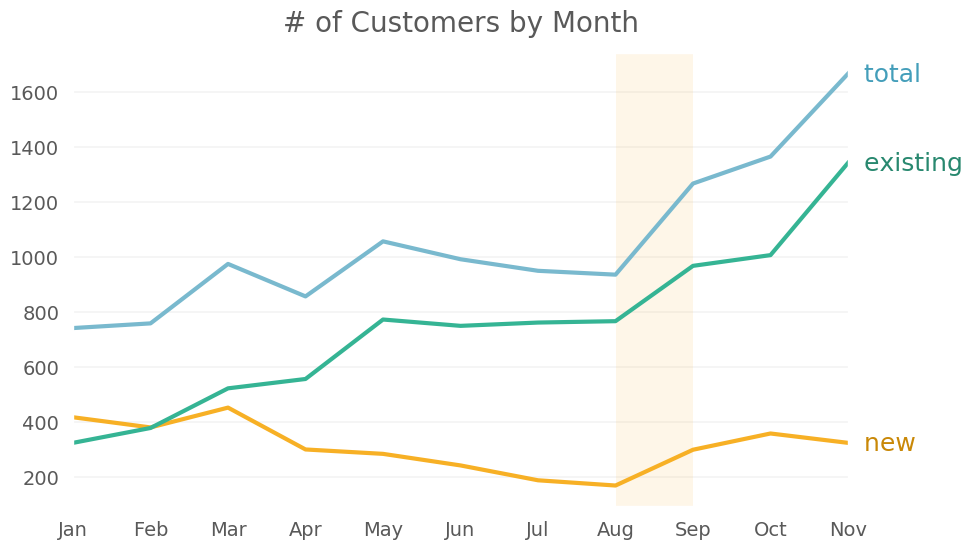

In [50]:
plot_style()

fig, ax1 = plt.subplots(figsize=[10,6], facecolor='white', dpi=100)
col_colors = [ color_dict[i] for i in ['b','y','g']]
text_colors = ['#449EBA','#C98807', '#28886F']

for col in range(3):
    monthly_customers.iloc[:12, col].plot(ax=ax1, color = col_colors[col], linewidth=3)

ax1.set_ylabel('')
ax1.set_xlabel('')
ax1.set_xticklabels([i for i in calendar.month_abbr][1:12])

plt.axvspan('2011-08', '2011-09', facecolor='#f7b025', alpha=0.1)
ax1.grid(color='lightgrey', which='major', axis='y', linewidth=0.3)
plt.legend().remove()

for index, value in enumerate(monthly_customers.iloc[10, :3].values):
    ax1.text('2011-11', value, '  ' + str(monthly_customers.columns[index]), va='center', color = text_colors[index], fontsize=18)

ax1.tick_params(axis='both', which='both', length=0, pad=10)

plt.title('# of Customers by Month', fontsize=20, y=1.03)

plt.savefig('The Composition of Customers by Month', facecolor='white', bbox_inches="tight", dpi=75)

* The plot exhibits how many customers made purchases and each line represents the class of customers.

* From August to September, both the numbers of new customers and existing customers apparently increased.

* Even if the new customers started rising slowly after September, existing customers kept moving up, and thus revenue increased as well.

### 2-3. Investigating Customers in August and September

To investigate what actually happened in August and September, I compare customers in two months and examine when they started their first purchases.

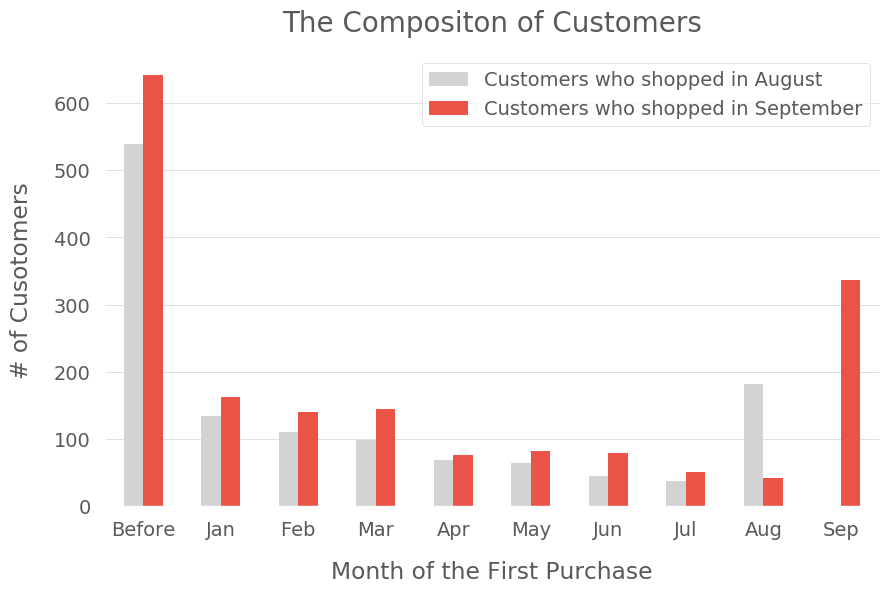

In [42]:
purchase_date = retail.groupby(['CustomerID', 'InvoiceNo'])[['yearmonth', 'first_ym']].first()
aug_sept = pd.merge(purchase_date.loc[purchase_date['yearmonth'] == '2011-08', 'first_ym'].value_counts().reset_index(),
                    purchase_date.loc[purchase_date['yearmonth'] == '2011-09', 'first_ym'].value_counts().reset_index(),
                    on='index', how='right').rename(columns={'first_ym_x':'2011-08', 'first_ym_y':'2011-09'}).sort_values('index').reset_index(drop=True).fillna(0)

plot_style()
fig, ax = plt.subplots(figsize=[10,6], dpi=100)

aug_sept.set_index('index').plot(kind='bar', ax=ax, color = ['lightgrey', color_dict['r']])

ax.set_xticklabels(['Before']+[calendar.month_abbr[i] for i in list(range(1,10))], rotation=0)
plt.xlabel('Month of the First Purchase', labelpad=15)
plt.ylabel('# of Cusotomers', labelpad=15)

plt.tick_params(axis='both', which='both', length=0, pad=10)
plt.grid(color='lightgrey', which='major', axis='y', linewidth=0.5)
plt.legend(labels=['Customers who shopped in August', 'Customers who shopped in September'], loc='upper right')

plt.title('The Compositon of Customers', fontsize=20, color=color_dict['title'], y=1.03)
plt.savefig('Joining Months of Customers in August and September', facecolor='white', bbox_inches="tight", dpi=85)

* In both months, a large proportion of customers were not new customers and began to buy before December 2010.

* September had more customers who started first purchases before July. However, seldom customers came from August because new customers might not immediately go shopping in the next month.

* In fact, the additional sales in September came from both new customers and repeated customers.

### 2-4. Source of Revenue

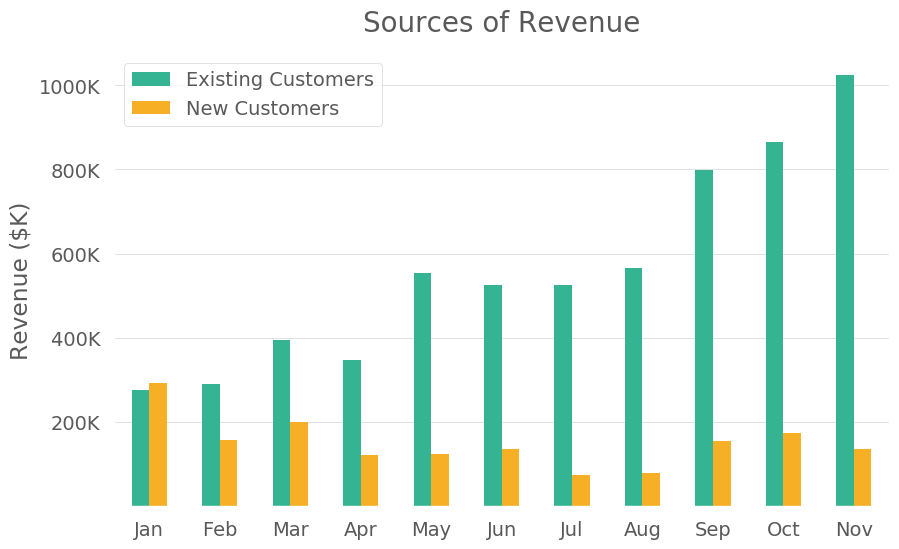

In [52]:
plt.style.use('ggplot')
mpl.rcParams['axes.facecolor'] = 'white'
plt.rc('font', **{'size'   : 14})
plt.rcParams.update(params)
fig, ax = plt.subplots(figsize=[10,6], dpi=100)

monthly_customers.loc['2011-01':'2011-11', ['sales_existing', 'sales_new']].plot(kind='bar', ax=ax, color = [color_dict['g'], color_dict['y']])

ax.set_yticks(np.arange(2e05,1e06+1,2e05))
ax.set_yticklabels([str(i) + 'K' for i in np.arange(200,1001,200)])
ax.set_ylabel('Revenue ($K)')

ax.set_xlabel('')
ax.set_xticklabels([calendar.month_abbr[i] for i in list(range(1,12))], rotation=0)

plt.tick_params(axis='both', which='both', length=0, pad=10)
plt.grid(color='lightgrey', which='major', axis='y', linewidth=0.5)
plt.legend(labels=['Existing Customers', 'New Customers'], loc='upper left')

plt.title('Sources of Revenue', fontsize=20, color='#595959', y=1.03)

plt.savefig('Sources of Sales', facecolor='white', bbox_inches="tight", dpi=85)

* By comparing the contribution of existing and new customers, except for in January, recurrent customers obviously bring about more profits than new customers. This gap between their contributions become much broader in the second half of the year.

* Benefits from repeated customers are considerable, although they require time to fetch.  

# Part 3. Cohort Analysis

As I observed before, new customers usually did not instantly generate high values, but if they are willing to come back, they can bring more and more sales. To examine customers' behavior from when they started buying, I executed a cohort analysis to measure metrics in different cohorts over time.

### 3-1. Retention Rate
I categorize customers into 10 groups according to the month of their first purchase and inspect how the retention rate fluctuated across months. Each row represents a group. For instance, row Jan means those customers who made their first order in January 2011. Columns are relative to the number of months customers had retained. The darkness of colors shows the retention rate. If the color is close to dark red, the retention rate is higher. 

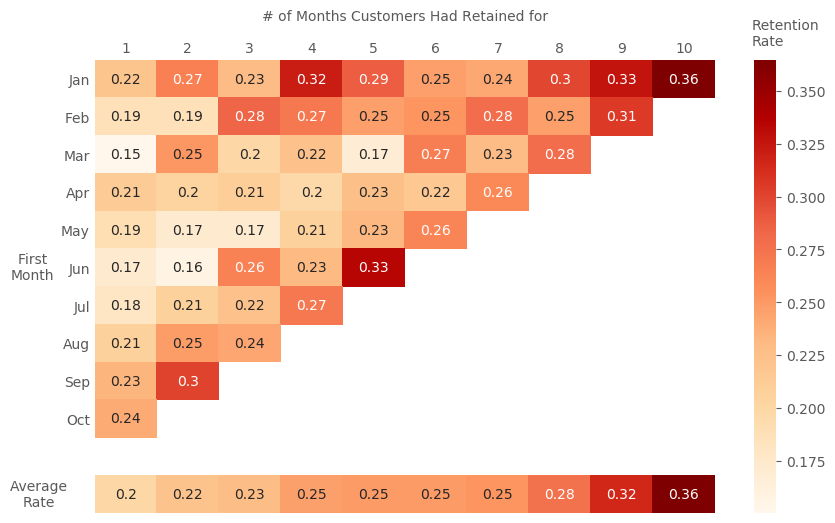

In [53]:
cohort = pd.pivot_table(retail.loc[retail['yearmonth'] != '2011-12'], index='first_ym', 
                        columns=['retain_months'], values='CustomerID', aggfunc=pd.Series.nunique).iloc[1:12, 0:11]
cohort_ratio = cohort.div(cohort[0], axis=0)
cohort_ratio.index = cohort_ratio.index.astype('str')
cohort_ratio.loc['Average Rate'] = cohort_ratio.mean(axis=0)

plt.rc('font', **{'size': 10})
plt.rcParams.update(params)
plt.figure(figsize=[10,6], dpi=100)

g = sns.heatmap(cohort_ratio.iloc[:,1:], cmap='OrRd', annot=True)
g.set_yticklabels([calendar.month_abbr[i] for i in list(range(1,11))], rotation=0)
g.set_ylabel('')
g.set_xlabel('# of Months Customers Had Retained for', labelpad=15, fontsize=10)
g.xaxis.set_ticks_position('top')
g.xaxis.set_label_position('top')
plt.tick_params(axis='both', which='both', length=0)

plt.text(-1, 5.5,'First\nMonth', ha='center', va='center', color=color_dict['title'])
plt.text(-0.9, 11.5,'Average\nRate', ha='center',va='center', color=color_dict['title'])
plt.text(10.6, -0.7,'Retention\nRate', ha='left',va='center', color=color_dict['title'])

plt.savefig('Retention Heatmap', facecolor='white', bbox_inches="tight", dpi=85)

* Cells in the diagonal line tend to have darker colors, indicating that those cells have higher retention rates.

* Average Rate, at the bottom of the plot, demonstrates that the longer time customer has retained for, the higher average retention rate is. It proved that new customers might not make purchases immediately in the next month, but they are likely to come back in the future.

### 3-2. Average Spending for an Individual Customer

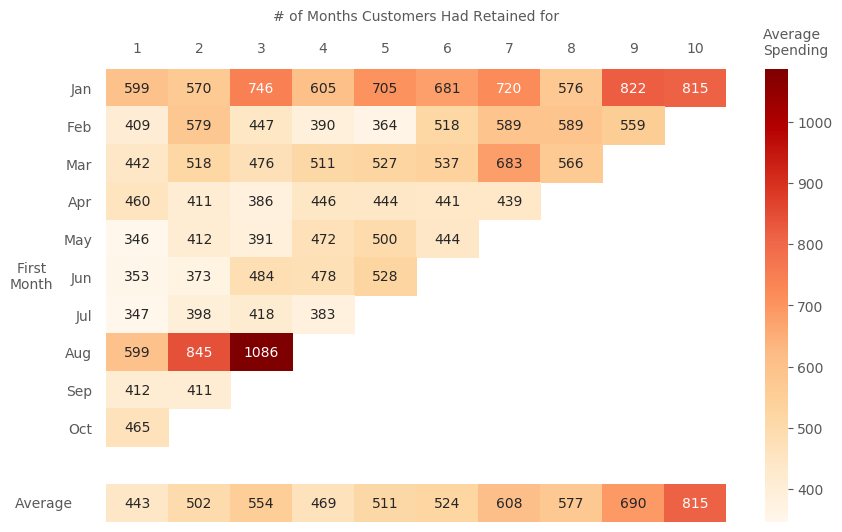

In [54]:
cohort_ratio = pd.pivot_table(retail.loc[retail['yearmonth'] != '2011-12'], index='first_ym', 
                              columns=['retain_months'], values='revenue', aggfunc='sum').iloc[1:12, 0:11]
cohort_ratio = cohort_ratio/cohort # calculate average revenue for each customer
cohort_ratio.index = cohort_ratio.index.astype('str')
cohort_ratio.loc['Average'] = cohort_ratio.mean(axis=0)
cohort_ratio = cohort_ratio.round()

plt.rc('font', **{'size': 10})
plt.rcParams.update(params)
plt.figure(figsize=[10,6], dpi=100)

g = sns.heatmap(cohort_ratio.iloc[:,1:], cmap='OrRd', annot=True, fmt='g')
g.set_yticklabels([calendar.month_abbr[i] for i in list(range(1,11))], rotation=0)
g.set_ylabel('')
g.set_xlabel('# of Months Customers Had Retained for', labelpad=15, fontsize=10)
g.xaxis.set_ticks_position('top')
g.xaxis.set_label_position('top')
plt.tick_params(axis='both', which='both', length=0, pad=10)

plt.text(-1.2, 5.5,'First\nMonth', ha='center', va='center', color=color_dict['title'])
plt.text(-1, 11.5,'Average', ha='center',va='center', color=color_dict['title'])
plt.text(10.6, -0.7,'Average\nSpending', ha='left',va='center', color=color_dict['title'])

#plt.show()
plt.savefig('Revenue Heatmap', facecolor='white', bbox_inches="tight", dpi=85)

* The graph is insightful and disclosed an really interesting fact: Cohorts in January and August perform far better than other groups.

* Customers who joined in January had the highest average spending when they retained for one month (in the first column). Subsequently, they continued to contribute more and more value over time. We can view them as customers with a higher loyalty.

* Customers who are acquired in August are notably profitable. In merely two months, they doubled the average spendings. We can conclude that marketing in August was surely successful because it remarkably raised revenue and cultivated a group of valuable customers.